# Mounting the google drive

> The dataset for the raw tweets, downloaded from <a href="https://www.kaggle.com/kazanova/sentiment140">Kaggle</a> are in my drive.

> In order to access the file, first mount the drive and enter the authentication with redirected URL.

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


> Now you can access the file by specifying a path to it

In [4]:
import os
import pandas as pd

# Specify the path to dataset and the file name
DATASET_DIR = os.path.join(os.getcwd(), r'drive/MyDrive/NLP Final Project/datasets/sentiment140_kaggle')
FILE = os.path.join(DATASET_DIR, r'training.1600000.processed.noemoticon.csv')

# Specify which columns to grab from the csv file.
columns = ['target', 'tweet']

# Open the csv file as a pandas DataFrame with specified columns
tweets_df = pd.read_csv(FILE, sep=',', encoding='utf-8', usecols=columns)
tweets_df

,target,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,4,Just woke up. Having no school is the best fee...
1599996,4,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...


> As per the kaggle dataset description, the target column contains only three values:

```
0 - negative
2 - neutral
4 - positive
```

In [5]:
ground_truth_sentiment = {
    0: "negative",
    2: "neutral",
    4: "positive"
}

> We will use `NRCLex` to annotate our dataset. So, we need to install it first!

In [6]:
!pip install nrclex

     |████████████████████████████████| 399kB 5.5MB/s 
  Created wheel for nrclex: filename=NRCLex-3.0.0-cp37-none-any.whl size=43310 sha256=90221914ca764c1ac9af7be6f4b884c23d56ae1226f9d200399e369aba75849f
  Stored in directory: /root/.cache/pip/wheels/17/31/64/035a8d245b4c217aeb8e8a2702d05dc91544b9c2334db72414
Successfully built nrclex


> We also need to download 'punkt' from `nltk`.

In [8]:
import nltk

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

> Let's explore a random tweet and it's associated ground truth label

> Here, we also calculate emotion scores and top emotions using `NRCLex` module

In [9]:
import random
from nrclex import NRCLex

# Generate a random index to grab a tweet and its label
random_index = random.randint(0, 1600000)

random_tweet_sentiment = ground_truth_sentiment[tweets_df.iloc[random_index, 0]]
random_tweet = tweets_df.iloc[random_index, -1]

text_obj = NRCLex(random_tweet)

print(f"Tweet : {random_tweet}")
print(f"Label : {random_tweet_sentiment}")
print()
print(f"NRC raw_emotion_scores :\n{text_obj.raw_emotion_scores}", end="\n\n")
print(f"NRC top_emotions  : {len(text_obj.top_emotions)}\n{text_obj.top_emotions}")

if not text_obj.raw_emotion_scores:
  index = tweets_df.loc[tweets_df['tweet'] == random_tweet].index.tolist()[0]
  assigned_label = ground_truth_sentiment[tweets_df.iloc[index, 0]]
else:
  assigned_label = text_obj.top_emotions[0][0]

print()
print("assigned label : ", assigned_label)

Tweet : @alwayscoffee Sweet! I wish I could poetry like you, you're so prolific. I just can't do poetry. I hardly understand it half the time. 
Label : negative

NRC raw_emotion_scores :
{'positive': 1, 'anticipation': 1}

NRC top_emotions  : 2
[('positive', 0.5), ('anticipation', 0.5)]

assigned label :  positive


> In the same way, we annotate the raw tweets based on emotion scores

In [10]:
def annotate(tweet, target):
    
    nrc_obj = NRCLex(tweet)

    raw_emotion_scores = nrc_obj.raw_emotion_scores
    top_emotions = nrc_obj.top_emotions

    if not raw_emotion_scores:
        return ground_truth_sentiment[target]
    else:
        return top_emotions[0][0]

In [11]:
%%time
tweets_df['label'] = tweets_df.apply(lambda x: annotate(x['tweet'], x['target']), axis=1)

CPU times: user 12min 4s, sys: 1.16 s, total: 12min 5s
Wall time: 12min 7s


In [12]:
tweets_df

,target,tweet,label
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",anger
1,0,is upset that he can't update his Facebook by ...,negative
2,0,@Kenichan I dived many times for the ball. Man...,positive
3,0,my whole body feels itchy and like its on fire,fear
4,0,"@nationwideclass no, it's not behaving at all....",fear
...,...,...,...
1599995,4,Just woke up. Having no school is the best fee...,trust
1599996,4,TheWDB.com - Very cool to hear old Walt interv...,positive
1599997,4,Are you ready for your MoJo Makeover? Ask me f...,anticipation
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...,negative


> Now, let's explore our dataset distribution on the 10 emotion classes

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


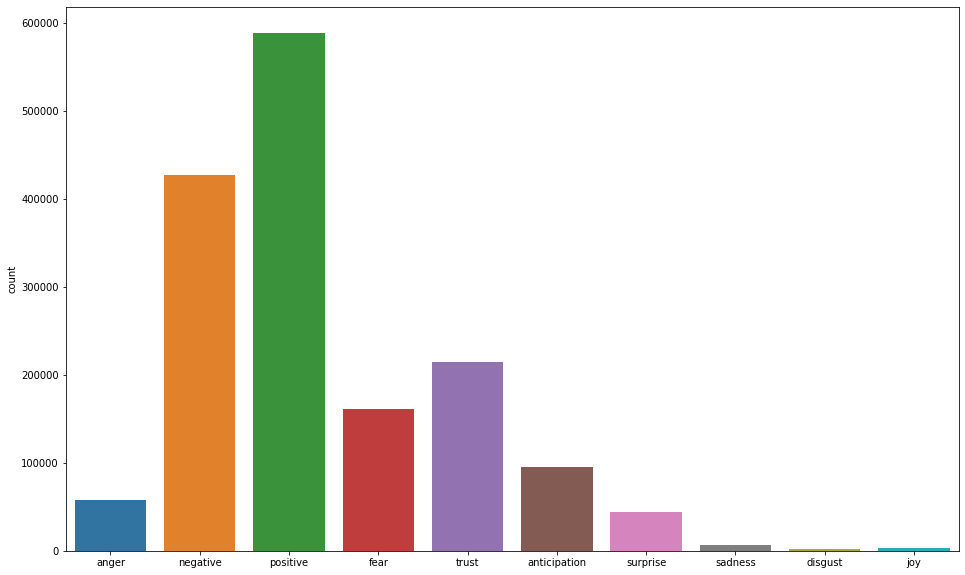

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 10))
sns.countplot(tweets_df.label.values)

> The dataset looks pretty imbalanced on the 10 classes as shown above.

> So, let's resample our dataset using `resample` tool from `sklearn.utils`

> And, let us pick a number, say 100,000 tweets to be present in each class

In [15]:
from sklearn.utils import resample

PICK_NUMBER = 100000

> First, seperate out the tweets according to the labels specifying which classes are majority (above PICK_NUMBER) and minority (below PICK_NUMBER)

In [16]:
# Separate majority and minority classes
df_majority_list = [
    
    tweets_df[tweets_df.label == "negative"],
    tweets_df[tweets_df.label == "positive"],
    tweets_df[tweets_df.label == "fear"],
    tweets_df[tweets_df.label == "trust"],
    
]



df_minority_list = [
                    
    tweets_df[tweets_df.label == "anger"],
    tweets_df[tweets_df.label == "anticipation"],
    tweets_df[tweets_df.label == "surprise"],
    tweets_df[tweets_df.label == "sadness"],
    tweets_df[tweets_df.label == "disgust"],
    tweets_df[tweets_df.label == "joy"],

]

> *Downsample* the majority classes

In [17]:
%%time
df_majority_downsampled_list = list()

for df_majority in df_majority_list:
    df_majority_downsampled_list.append(
        resample(df_majority, replace=True, n_samples=PICK_NUMBER)
    )

CPU times: user 93.7 ms, sys: 988 µs, total: 94.7 ms
Wall time: 103 ms


> *Upsample* the minority classes

In [18]:
%%time
df_minority_upsampled_list = list()

for df_minority in df_minority_list:
    df_minority_upsampled_list.append(
        resample(df_minority, replace=True, n_samples=PICK_NUMBER)
    )

CPU times: user 54.2 ms, sys: 993 µs, total: 55.2 ms
Wall time: 58.4 ms


> Now, combine all the resampled data back into a new DataFrame

In [19]:
df_resampled = df_majority_downsampled_list
df_resampled.extend(df_minority_upsampled_list)
tweets_resampled_df = pd.concat(df_resampled)

tweets_resampled_df

,target,tweet,label
158265,0,I think I stuffed up,negative
391934,0,it's only 1:30.. why am i so tired?,negative
429811,0,Anybody awake ...no? goodnight. haha,negative
504799,0,@Creide13 You saw Afifa? When? Jealous here!,negative
147336,0,"is eating maltesers, have work at 5",negative
...,...,...,...
208118,0,the pollen is getting rediculous; it looks lik...,joy
1082604,4,beach again!... with the sister wahooo!!! plea...,joy
985874,4,"@kellybbz i'll give you a clue, u have to sele...",joy
526397,0,Got an awesome large beach towel of 'Animal' f...,joy


> Now, let's see the distribution of data on resampled DataFrame.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


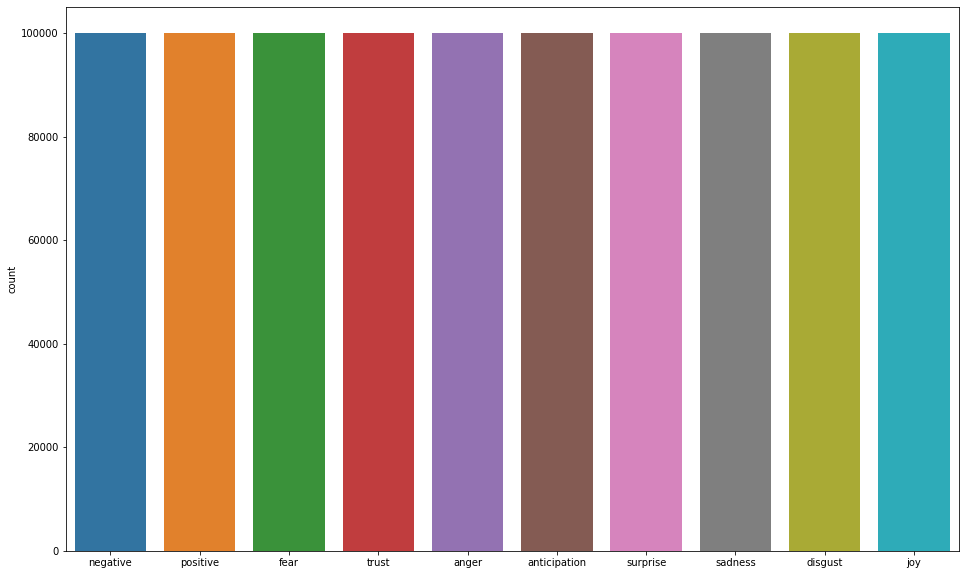

In [20]:
plt.figure(figsize=(16, 10))
sns.countplot(tweets_resampled_df.label.values)

> Yes, the dataset looks balanced now. Now save the DataFrame as a csv file to disk.

Warning: The data has already been saved! No need to run the cell again.

In [ ]:
NEW_FILE = os.path.join(DATASET_DIR, r'Sentiment140.annotated.resampled.50000.csv')
tweets_resampled_df.to_csv(NEW_FILE, encoding='utf-8', sep=',', index=False, header=True)